**tradSISOnoCSI**<br>
by $\text{Rishabh Pomaje}$ 

- This file contains the code that simulates Orthogonal Signalling and measures the system performance.
- The results are meant to be used as benchmarks for the DNN learnt in the file $\color{cornflowerblue}{deepSISOnoCSI.ipynb}$
- Two pipelines considered as follows :<br>
    1. No channel coding
    2. Channel coding with Hamming (7, 4) code<br>
        - Hard Decision and Syndrome Correction 

In [1]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'

- Function definitions

In [2]:
# Importing from custom made module : CommSysLib
import CommSysLib as csl

- Some other definitions :
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = N_0 \;\dots (E_b = 1) 
\end{equation*}

\begin{equation*}
    \frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times 2N_0}{2 \times k \times E_b} = \frac{nN_0}{kE_b} = nN_0/k \;\dots (E_b = 1)
\end{equation*}

- System Parameters

In [3]:
k, n = 4, 7         # Uncoded and coded block length  
R = k / n           # Information rate (R) 
E_b = 1             # Energy per bit

# Signal-to-noise ratio (SNR) range in dB scale and linear scale:
n_points = 30
SNR_dB = np.linspace(-2, 20, n_points)
SNR_lin = 10 ** (SNR_dB / 10)
# AWGN noise variance : this is total (I + Q) noise
noise_var_uncoded =  1 / (2 * 1 * SNR_lin) # For uncoded
noise_var_coded =  1 / (2 * R * SNR_lin) # For coded
# Fading model (Rayleigh) parameters : Only real or imag component
fade_mean = 0
fade_std = np.sqrt(0.5)

- Data Generation (Random binary data)

In [4]:
n_bits = 4 * (10 ** 6)          
n_bits_c = n_bits * n // k      
binary_stream_tx = np.random.randint(0, 2, n_bits)

print(f'Samples : {binary_stream_tx[:10]}')

Samples : [0 1 1 0 1 0 1 1 0 0]


### Without channel coding 

- Orthogonal Signalling 

In [5]:
signal_stream_tx = csl.pulse_pos_modulation(binary_stream_tx, E_b)
print(f'Samples = {signal_stream_tx[:20]}')

Samples = [1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]


- Simulating the channel and the decoding

In [6]:
BLER_uncoded_ortho = []
count = 0 
for noise in noise_var_uncoded:
    # Fading 
    fade_taps = np.random.normal(fade_mean, fade_std, 2*n_bits) + 1j * np.random.normal(fade_mean, fade_std, 2*n_bits)
    signal_stream_rx = fade_taps * signal_stream_tx
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), 2*n_bits) + 1j * np.random.normal(0, np.sqrt(noise/2), 2*n_bits)
    signal_stream_rx = signal_stream_rx + noise_samples
    # Decoding at the receiver
    binary_stream_rx = csl.square_law_detector(signal_stream_rx)
    # Analysis 
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_uncoded_ortho.append(BLER)
    # Progress update 
    count += 1 
    print(f'Progress : {100 * count // n_points} %', end='\r')

### With Channel Coding

- Channel Coding

In [7]:
#  (7, 4) Hamming Code :
# Generator matrix 
G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ], dtype=int)
# Parity Check matrix
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
    ], dtype=int)

channel_coded_stream_tx = csl.hamming_encoder(binary_stream_tx, G)
print(f'Samples : {channel_coded_stream_tx[:10]}')

Samples : [0 1 1 0 1 1 0 1 0 1]


- Orthogonal Signalling

In [8]:
signal_stream_tx = csl.pulse_pos_modulation(channel_coded_stream_tx, E_b)
print(f'Samples : {signal_stream_tx[:20]}')

Samples : [1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]


In [9]:
print(np.linalg.norm(signal_stream_tx) ** 2)

6999999.999999999


- Simulating the channel and the receiver 

1. Hard Decoding + Syndrome-based correction   

In [10]:
BLER_coded_ortho_hard = []
count = 0 
for noise in noise_var_coded:
    # Fading 
    fade_taps = np.random.normal(fade_mean, fade_std, n_bits_c*2) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c*2)
    signal_stream_rx = fade_taps * signal_stream_tx    
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), n_bits_c*2) + 1j * np.random.normal(0, np.sqrt(noise/2), n_bits_c*2) 
    signal_stream_rx = signal_stream_rx + noise_samples 
    # Decoding 
    binary_coded_stream_rx = csl.square_law_detector(signal_stream_rx)
    # Correction 
    binary_stream_rx = csl.hamming_decoder(binary_coded_stream_rx, H)
    # Analysis 
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_ortho_hard.append(BLER)
    # Progress Update 
    count += 1 
    print(f'Progress : {100 * count // n_points} %', end='\r') 

- Visualization of the results 

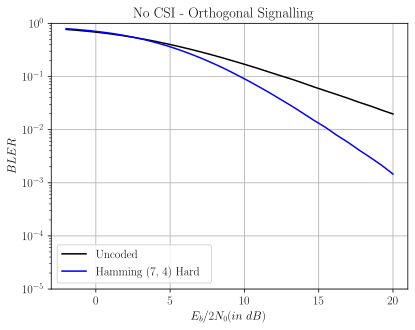

In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 12,
    "font.family" : 'Serif'
})
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_uncoded_ortho, label='Uncoded', color='black')
axes.semilogy(SNR_dB, BLER_coded_ortho_hard, label='Hamming (7, 4) Hard', color='blue')

# Markings 
axes.set_xlabel(r'$E_b/2N_0 (in\ dB)$')
axes.set_ylabel(r'$BLER$')
axes.set_ylim(10**-5,10**0)
axes.set_xlim(-3, 21)
axes.legend()
axes.set_title(f'No CSI - Orthogonal Signalling')
axes.grid(True, which="major")

In [12]:
# Saving the figure for future reference 
fig.savefig("plots/tradSISOnoCSI.svg", transparent=True)
with open(file="results/tradSISOnoCSI.txt", mode='w') as file_id:
    file_id.write(f'BLER_uncoded_ortho = {BLER_uncoded_ortho}\n')
    file_id.write(f'BLER_coded_ortho_hard = {BLER_coded_ortho_hard}')

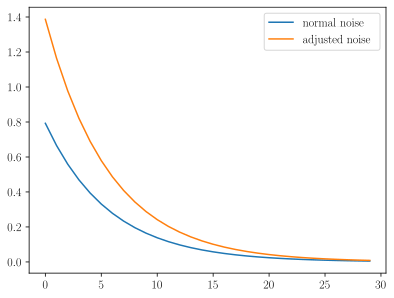

In [13]:
plt.plot(noise_var_uncoded, label='normal_noise')
plt.plot(noise_var_coded, label='adjusted noise')
plt.legend()